In [4]:
import pandas as pd
import csv
import pickle
import numpy as np
from IPython.display import display
import multiprocessing
from multiprocessing import Pool
import math
from tqdm import tqdm
import time
import traceback
import json
import os
import multiprocessing
cpu_count = multiprocessing.cpu_count()

import xgboost as xgb

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn import svm
from pandas import *
from pprint import pprint
import sys
from sklearn.utils import resample

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:


# path = "F:\\twitter_data\\givenchy\\pickle\\"
# event = 'givenchy'
# interval = 30
# current_time = 360
# start_hour = 6


def load_pickle_file(pickled_file):
    print(f'Loading data file from {pickled_file}')
    infile = open(pickled_file,'rb')
    unpickled_file = pickle.load(infile)
    print(f'Loaded {len(unpickled_file)} entries')
    infile.close()
    return unpickled_file
          
    
def save_pickle_file(path, data):
    print('Dumping data to path {}'.format(path))
    with open(path, 'wb') as file:
        pickle.dump(data, file)
    print('Finished dumping data to path {}'.format(path))


def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


def safe_division(x, y):
    if y == 0:
        return 0
    else:
        return x/y

    
# users = load_pickle_file(path+"users.dat")
# users.reset_index(drop =True , inplace =True)
# # print(users)
# print(users.columns)
# print(users['source_candidates'])


# print(unique_users)
def id_exists(unique_users, uid):
    if uid in unique_users:
        return True
    return False

def filter_id_list(unique_users, value):
        return list(filter(lambda uid: id_exists(unique_users,uid), value))
    

def network_simulation_init(users, start_hour):
    current_time = start_hour*60 
    network_simulation = pd.DataFrame(columns= ['id','time_lapsed','favourites_count','followers_count','friends_count',
                                'listed_count','statuses_count','source_candidates','source_index','seed_index','generation',
                                 'time_since_seed','user_created_days','normalized_statuses_count','normalized_followers_count',
                                 'normalized_favourites_count','normalized_listed_count','normalized_friends_count'])

    network_simulation['id']=users['id']
    network_simulation['favourites_count']=users['favourites_count']
    network_simulation['followers_count']=users['followers_count']
    network_simulation['friends_count']=users['friends_count']
    network_simulation['listed_count']=users['listed_count']
    network_simulation['statuses_count']=users['statuses_count']
    network_simulation['user_created_days']=users['user_created_days']
    network_simulation['normalized_statuses_count']=users['normalized_statuses_count']
    network_simulation['normalized_followers_count']=users['normalized_followers_count']
    network_simulation['normalized_favourites_count']=users['normalized_favourites_count']
    network_simulation['normalized_listed_count']=users['normalized_listed_count']
    network_simulation['normalized_friends_count']=users['normalized_friends_count']
#     network_simulation['followers_list'] =users['followers_json'] 
#     network_simulation['friends_list'] =users['friends_json']
    network_simulation['time_lapsed'] = users['time_lapsed'].apply(lambda x: x if x <= current_time else None)
    network_simulation['source_index'] = users.apply(lambda x: x['source_index'] if x['time_lapsed'] <= current_time else None,axis=1)
    network_simulation['seed_index'] = users.apply(lambda x: x['seed_index'] if x['time_lapsed'] <= current_time else None,axis=1)
    network_simulation['generation'] = users.apply(lambda x: x['generation'] if x['time_lapsed'] <= current_time else None,axis=1)
    network_simulation['time_since_seed'] = users.apply(lambda x: x['time_since_seed'] if x['time_lapsed'] <= current_time else None,axis=1)

# print("network_simulation")
# print(network_simulation)
    return network_simulation


def network_simulation_merge_friends_list(network_simulation, path_of_friends_list):

    friends = load_pickle_file(path_of_friends_list)
    friends_list = pd.DataFrame(columns=['id'], data=friends.keys())
    friends_list["friends_list"] = ''
    for i in range (0, len(friends)):
        friends_list["friends_list"][i]= friends.get(friends_list["id"][i])
    friends_list.reset_index(drop =True , inplace =True)
    return pd.merge(network_simulation,friends_list, on='id', how='left')
    

def network_simulation_merge_followers_list(network_simulation, path_of_followers_list):
    followers = load_pickle_file(path_of_followers_list)
    followers_list = pd.DataFrame(columns=['id'], data=followers.keys())
    followers_list["followers_list"] = ''
    for i in range (0, len(followers)):
        followers_list["followers_list"][i]= followers.get(followers_list["id"][i])
    # print(friends_list.get(942362499923566592 ))
    followers_list.reset_index(drop =True , inplace =True)
    # print(followers_list)


    return pd.merge(network_simulation,followers_list,on='id',how='left')
    
#     print(network_simulation)



def process_data(users, network_simulation, start_index, end_index,start_hour):
    
    current_time = start_hour*60   
    in_degree = list(users.friends_count)
    out_degree = list(users.followers_count)
    degree = (users.friends_count+users.followers_count).tolist()
    
    features = {
        #Columns which are added for simulation, but they are not used as features for model prediction
        'user_id':[],
        'infected_status':[],
        'infection_time':[],
        'followers_list':[],
        
        #Columns used as features for model prediction   33
        'UsM_deltaDays': [],
        'UsM_statusesCount': [],
        'UsM_followersCount': [],
        'UsM_favouritesCount': [],
        'UsM_friendsCount': [],
        'UsM_listedCount': [],
        'UsM_normalizedUserStatusesCount': [],
        'UsM_normalizedUserFollowersCount': [],
        'UsM_normalizedUserFavouritesCount': [],
        'UsM_normalizedUserListedCount': [],
        'UsM_normalizedUserFriendsCount': [],          
        'UsM_deltaDays0': [],
        'UsM_statusesCount0': [],
        'UsM_followersCount0': [],
        'UsM_favouritesCount0': [],
        'UsM_friendsCount0': [],
        'UsM_listedCount0': [],
        'UsM_normalizedUserStatusesCount0': [],
        'UsM_normalizedUserFollowersCount0': [],
        'UsM_normalizedUserFavouritesCount0': [],
        'UsM_normalizedUserListedCount0': [],
        'UsM_normalizedUserFriendsCount0': [],
        'UsM_deltaDays-1': [],
        'UsM_statusesCount-1': [],
        'UsM_followersCount-1': [],
        'UsM_favouritesCount-1': [],
        'UsM_friendsCount-1': [],
        'UsM_listedCount-1': [],
        'UsM_normalizedUserStatusesCount-1': [],
        'UsM_normalizedUserFollowersCount-1': [],
        'UsM_normalizedUserFavouritesCount-1': [],
        'UsM_normalizedUserListedCount-1': [],
        'UsM_normalizedUserFriendsCount-1': [],
        # TwM: Tweet metadata   5
        'TwM_t0': [],
        'TwM_tSeed0': [],
        'TwM_t-1': [],
        'TwM_tSeed-1': [],
        'TwM_tCurrent': [],
        # Nw: Network0    15
        'Nw_degree': [],
        'Nw_inDegree': [],
        'Nw_outDegree': [],
        'Nw_degree0': [],
        'Nw_inDegree0': [],
        'Nw_outDegree0': [],
        'Nw_degree-1': [],
        'Nw_inDegree-1': [],
        'Nw_outDegree-1': [],
        'Nw_degreeSeed0': [],
        'Nw_inDegreeSeed0': [],
        'Nw_outDegreeSeed0': [],
        'Nw_degreeSeed-1': [],
        'Nw_inDegreeSeed-1': [],
        'Nw_outDegreeSeed-1': [],
        # SNw: Spreading Network   20
        'SNw_nFriendsInfected': [],
        'SNw_friendsInfectedRatio': [],
        'SNw_generation0': [],
        'SNw_generation-1': [],
        'SNw_timeSinceSeed0': [],
        'SNw_timeSinceSeed-1': [],
        'SNw_totalNodesInfected': [],
        'SNw_nodeInfectedCentrality': [],
        'SNw_totalInDegree': [],
        'SNw_totalOutDegree': [],
        'SNw_inDegreeCentrality': [],
        'SNw_inDegreeCentrality0': [],
        'SNw_inDegreeCentrality-1': [],
        'SNw_outDegreeCentrality': [],
        'SNw_outDegreeCentrality0': [],
        'SNw_outDegreeCentrality-1': [],
        'SNw_inDegreeCentralitySeed0':[],
        'SNw_outDegreeCentralitySeed0':[],
        'SNw_inDegreeCentralitySeed-1':[],
        'SNw_outDegreeCentralitySeed-1':[],
        # Stat: Statistical  15
        'Stat_average_kOut': [],
        'Stat_average_t': [],
        'Stat_average_deltaDays': [],
        'Stat_average_statusesCount': [],
        'Stat_average_followersCount': [],
        'Stat_average_favouritesCount': [],
        'Stat_average_friendsCount': [],
        'Stat_average_listedCount': [],
        'Stat_average_normalizedUserStatusesCount': [],
        'Stat_average_normalizedUserFollowersCount': [],
        'Stat_average_normalizedUserFavouritesCount': [],
        'Stat_average_normalizedUserListedCount': [],
        'Stat_average_normalizedUserFriendsCount': [],                
        'Stat_max_kOut': [],
        'Stat_min_kOut': []
        
    }

    with tqdm(total=len(list(users[start_index: end_index].iterrows()))) as pbar: 
        for index, user_row in users[start_index: end_index].iterrows():
            source_candidates = sorted(user_row['source_candidates'])
            features['user_id'].append(user_row['id'])
            features['infected_status'].append(False)
            features['infection_time'].append(None)
            #print(f"user_row['followers_list']:{user_row['followers_list']}")
            features['followers_list'].append(user_row['followers_json'])
            #print("b")
            features['UsM_deltaDays'].append(user_row['user_created_days'])
            features['UsM_statusesCount'].append(user_row['statuses_count'])
            features['UsM_followersCount'].append(user_row['followers_count'])
            features['UsM_favouritesCount'].append(user_row['favourites_count'])
            features['UsM_friendsCount'].append(user_row['friends_count'])
            features['UsM_listedCount'].append(user_row['listed_count'])
            features['UsM_normalizedUserStatusesCount'].append(user_row['normalized_statuses_count'])
            features['UsM_normalizedUserFollowersCount'].append(user_row['normalized_followers_count'])
            features['UsM_normalizedUserFavouritesCount'].append(user_row['normalized_favourites_count'])
            features['UsM_normalizedUserListedCount'].append(user_row['normalized_listed_count'])
            features['UsM_normalizedUserFriendsCount'].append(user_row['normalized_friends_count'])
            if isinstance(source_candidates, list):
                sources = network_simulation.loc[source_candidates]
                sources_dataframe = sources[sources['time_lapsed'] <= current_time]
#                 if user_row['time_lapsed'] > current_time:
#                     sources_dataframe = sources[sources['time_lapsed'] <= current_time]
#                 else:
#                      sources_dataframe = sources[sources['time_lapsed'] <= user_row['time_lapsed']]
                sources = sources_dataframe.index.tolist()
            else:
                sources = []
            #sources = [x for x in source_candidates if users.loc[x,'time_lapsed'] <= current_time]
            #print(f'sources:{sources}')
            if len(sources) > 0:

                # Assign the values here to save computation
                first_source_index = source_candidates[0]
                first_source_row = users.loc[first_source_index]
                first_source_seed_row = users.loc[first_source_row['seed_index']]

                inDegreeList = sources_dataframe.friends_count.tolist()
                outDegreeList = sources_dataframe.followers_count.tolist()
                degreeList = [x + y for x, y in zip(inDegreeList, outDegreeList)]
                
                s_ind = sources_dataframe.friends_count
                s_outd = sources_dataframe.followers_count
                outDegreeList = s_outd.tolist()
                inDegreeList = s_ind.tolist()
                degreeList = (s_ind + s_outd).tolist()

                #degreeList = list(users.loc[i, 'followers_count'] + users.loc[i, 'friends_count']  for i in sources)
                current_time_series = pd.Series([current_time] * len(sources))
                time_lapsed_series = sources_dataframe.time_lapsed
                timeList = (current_time_series - time_lapsed_series).tolist()


                last_source_index = sources[-1]
                last_source_row = network_simulation.loc[last_source_index]
                last_source_seed_row = network_simulation.loc[last_source_row['seed_index']]

                usr_index = index

                if user_row['time_lapsed'] <= current_time:

                    features['infected_status'][-1] = True
                    features['infection_time'][-1] = user_row['time_lapsed']

                    network_simulation.loc[usr_index,'time_lapsed'] = user_row['time_lapsed']

                    network_simulation.loc[usr_index,'source_index'] = user_row['source_index']
                    network_simulation.loc[usr_index,'seed_index'] = user_row['seed_index']
                    network_simulation.loc[usr_index, 'generation'] = user_row['generation']
                    network_simulation.loc[usr_index, 'time_since_seed'] = user_row['time_since_seed']


                network_simulation.at[usr_index,'source_candidates'] = sources

                # UsM: User metadata

                features['UsM_deltaDays0'].append(first_source_row.user_created_days)
                features['UsM_statusesCount0'].append(first_source_row.statuses_count)
                features['UsM_followersCount0'].append(first_source_row.followers_count)
                features['UsM_favouritesCount0'].append(first_source_row.favourites_count)
                features['UsM_friendsCount0'].append(first_source_row.friends_count)
                features['UsM_listedCount0'].append(first_source_row.listed_count)
                features['UsM_normalizedUserStatusesCount0'].append(first_source_row.normalized_statuses_count)
                features['UsM_normalizedUserFollowersCount0'].append(first_source_row.normalized_followers_count)
                features['UsM_normalizedUserFavouritesCount0'].append(first_source_row.normalized_favourites_count)
                features['UsM_normalizedUserListedCount0'].append(first_source_row.normalized_listed_count)
                features['UsM_normalizedUserFriendsCount0'].append(first_source_row.normalized_friends_count)
                features['UsM_deltaDays-1'].append(last_source_row.user_created_days)
                features['UsM_statusesCount-1'].append(last_source_row.statuses_count)
                features['UsM_followersCount-1'].append(last_source_row.followers_count)
                features['UsM_favouritesCount-1'].append(last_source_row.favourites_count)
                features['UsM_friendsCount-1'].append(last_source_row.friends_count)
                features['UsM_listedCount-1'].append(last_source_row.listed_count)
                features['UsM_normalizedUserStatusesCount-1'].append(last_source_row.normalized_statuses_count)
                features['UsM_normalizedUserFollowersCount-1'].append(last_source_row.normalized_followers_count)
                features['UsM_normalizedUserFavouritesCount-1'].append(last_source_row.normalized_favourites_count)
                features['UsM_normalizedUserListedCount-1'].append(last_source_row.normalized_listed_count)
                features['UsM_normalizedUserFriendsCount-1'].append(last_source_row.normalized_friends_count)
                # TwM: Tweet metadata
                features['TwM_t0'].append(round(timeList[0], 1))
                features['TwM_tSeed0'].append(round(current_time - first_source_seed_row['time_lapsed'], 1))
                features['TwM_t-1'].append(round(timeList[-1], 1))
                features['TwM_tSeed-1'].append(round(current_time - last_source_seed_row['time_lapsed'], 1))
                features['TwM_tCurrent'].append(current_time)
                # Nw: Network
                features['Nw_degree'].append(degree[index])
                features['Nw_inDegree'].append(in_degree[index])
                features['Nw_outDegree'].append(out_degree[index])
                features['Nw_degree0'].append(degree[first_source_index])
                features['Nw_inDegree0'].append(in_degree[first_source_index])
                features['Nw_outDegree0'].append(out_degree[first_source_index])
                features['Nw_degree-1'].append(degree[last_source_index])
                features['Nw_inDegree-1'].append(in_degree[last_source_index])
                features['Nw_outDegree-1'].append(out_degree[last_source_index])
                features['Nw_degreeSeed0'].append(degree[int(first_source_row['seed_index'])])
                features['Nw_inDegreeSeed0'].append(in_degree[int(first_source_row['seed_index'])])
                features['Nw_outDegreeSeed0'].append(out_degree[int(first_source_row['seed_index'])])
                features['Nw_degreeSeed-1'].append(degree[int(last_source_row['seed_index'])])
                features['Nw_inDegreeSeed-1'].append(in_degree[int(last_source_row['seed_index'])])
                features['Nw_outDegreeSeed-1'].append(out_degree[int(last_source_row['seed_index'])])
                # SNw: Spreading Network
                features['SNw_nFriendsInfected'].append(len(sources))
                features['SNw_friendsInfectedRatio'].append(safe_division(len(sources), user_row['friends_count']))
                features['SNw_generation0'].append(first_source_row['generation'])
                features['SNw_generation-1'].append(last_source_row['generation'])
                features['SNw_timeSinceSeed0'].append(first_source_row['time_since_seed'])
                features['SNw_timeSinceSeed-1'].append(last_source_row['time_since_seed'])

                infected_dataframe = network_simulation[network_simulation.time_lapsed <= current_time]
                total_nodes_infected = infected_dataframe.shape[0]
                total_in_degree = sum(infected_dataframe.friends_count)
                total_out_degree = sum(infected_dataframe.followers_count)

                features['SNw_totalNodesInfected'].append(total_nodes_infected)
                features['SNw_nodeInfectedCentrality'].append(len(sources)/total_nodes_infected)
                features['SNw_totalInDegree'].append(total_in_degree)
                features['SNw_totalOutDegree'].append(total_out_degree)
                features['SNw_inDegreeCentrality'].append(in_degree[index]/total_in_degree)
                features['SNw_inDegreeCentrality0'].append(in_degree[first_source_index]/total_in_degree)
                features['SNw_inDegreeCentrality-1'].append(in_degree[last_source_index]/total_in_degree)
                features['SNw_outDegreeCentrality'].append(out_degree[index]/total_out_degree)
                features['SNw_outDegreeCentrality0'].append(out_degree[first_source_index]/total_out_degree)
                features['SNw_outDegreeCentrality-1'].append(out_degree[last_source_index]/total_out_degree)
                features['SNw_inDegreeCentralitySeed0'].append(in_degree[int(first_source_row['seed_index'])]/total_in_degree)
                features['SNw_outDegreeCentralitySeed0'].append(out_degree[int(first_source_row['seed_index'])]/total_out_degree)
                features['SNw_inDegreeCentralitySeed-1'].append(in_degree[int(last_source_row['seed_index'])]/total_in_degree)
                features['SNw_outDegreeCentralitySeed-1'].append(out_degree[int(last_source_row['seed_index'])]/total_out_degree)
                # Stat: Statistical
                features['Stat_average_kOut'].append(round(mean(degreeList), 1))
                features['Stat_average_t'].append(round(mean(timeList), 1))
                features['Stat_average_deltaDays'].append(sources_dataframe.user_created_days.mean())
                features['Stat_average_statusesCount'].append(sources_dataframe.statuses_count.mean())
                features['Stat_average_followersCount'].append(sources_dataframe.followers_count.mean())
                features['Stat_average_favouritesCount'].append(sources_dataframe.favourites_count.mean())
                features['Stat_average_friendsCount'].append(sources_dataframe.friends_count.mean())
                features['Stat_average_listedCount'].append(sources_dataframe.listed_count.mean())
                features['Stat_average_normalizedUserStatusesCount'].append(sources_dataframe.normalized_statuses_count.mean())
                features['Stat_average_normalizedUserFollowersCount'].append(sources_dataframe.normalized_followers_count.mean())
                features['Stat_average_normalizedUserFavouritesCount'].append(sources_dataframe.normalized_favourites_count.mean())
                features['Stat_average_normalizedUserListedCount'].append(sources_dataframe.normalized_listed_count.mean())
                features['Stat_average_normalizedUserFriendsCount'].append(sources_dataframe.normalized_friends_count.mean())
                features['Stat_max_kOut'].append(max(degreeList))
                features['Stat_min_kOut'].append(min(degreeList))
            else:
                features['UsM_deltaDays0'].append(None)
                features['UsM_statusesCount0'].append(None)
                features['UsM_followersCount0'].append(None)
                features['UsM_favouritesCount0'].append(None)
                features['UsM_friendsCount0'].append(None)
                features['UsM_listedCount0'].append(None)
                features['UsM_normalizedUserStatusesCount0'].append(None)
                features['UsM_normalizedUserFollowersCount0'].append(None)
                features['UsM_normalizedUserFavouritesCount0'].append(None)
                features['UsM_normalizedUserListedCount0'].append(None)
                features['UsM_normalizedUserFriendsCount0'].append(None)
                features['UsM_deltaDays-1'].append(None)
                features['UsM_statusesCount-1'].append(None)
                features['UsM_followersCount-1'].append(None)
                features['UsM_favouritesCount-1'].append(None)
                features['UsM_friendsCount-1'].append(None)
                features['UsM_listedCount-1'].append(None)
                features['UsM_normalizedUserStatusesCount-1'].append(None)
                features['UsM_normalizedUserFollowersCount-1'].append(None)
                features['UsM_normalizedUserFavouritesCount-1'].append(None)
                features['UsM_normalizedUserListedCount-1'].append(None)
                features['UsM_normalizedUserFriendsCount-1'].append(None)
                # TwM: Tweet metadata
                features['TwM_t0'].append(None)
                features['TwM_tSeed0'].append(None)
                features['TwM_t-1'].append(None)
                features['TwM_tSeed-1'].append(None)
                features['TwM_tCurrent'].append(None)
                # Nw: Network
                features['Nw_degree'].append(None)
                features['Nw_inDegree'].append(None)
                features['Nw_outDegree'].append(None)
                features['Nw_degree0'].append(None)
                features['Nw_inDegree0'].append(None)
                features['Nw_outDegree0'].append(None)
                features['Nw_degree-1'].append(None)
                features['Nw_inDegree-1'].append(None)
                features['Nw_outDegree-1'].append(None)
                features['Nw_degreeSeed0'].append(None)
                features['Nw_inDegreeSeed0'].append(None)
                features['Nw_outDegreeSeed0'].append(None)
                features['Nw_degreeSeed-1'].append(None)
                features['Nw_inDegreeSeed-1'].append(None)
                features['Nw_outDegreeSeed-1'].append(None)
                # SNw: Spreading Network
                features['SNw_nFriendsInfected'].append(0)
                features['SNw_friendsInfectedRatio'].append(None)
                features['SNw_generation0'].append(None)
                features['SNw_generation-1'].append(None)
                features['SNw_timeSinceSeed0'].append(None)
                features['SNw_timeSinceSeed-1'].append(None)
                features['SNw_totalNodesInfected'].append(None)
                features['SNw_nodeInfectedCentrality'].append(None)
                features['SNw_totalInDegree'].append(None)
                features['SNw_totalOutDegree'].append(None)
                features['SNw_inDegreeCentrality'].append(None)
                features['SNw_inDegreeCentrality0'].append(None)
                features['SNw_inDegreeCentrality-1'].append(None)
                features['SNw_outDegreeCentrality'].append(None)
                features['SNw_outDegreeCentrality0'].append(None)
                features['SNw_outDegreeCentrality-1'].append(None)
                features['SNw_inDegreeCentralitySeed0'].append(None)
                features['SNw_outDegreeCentralitySeed0'].append(None)
                features['SNw_inDegreeCentralitySeed-1'].append(None)
                features['SNw_outDegreeCentralitySeed-1'].append(None)
                # Stat: Statistical
                features['Stat_average_kOut'].append(None)
                features['Stat_average_t'].append(None)
                features['Stat_average_deltaDays'].append(None)
                features['Stat_average_statusesCount'].append(None)
                features['Stat_average_followersCount'].append(None)
                features['Stat_average_favouritesCount'].append(None)
                features['Stat_average_friendsCount'].append(None)
                features['Stat_average_listedCount'].append(None)
                features['Stat_average_normalizedUserStatusesCount'].append(None)
                features['Stat_average_normalizedUserFollowersCount'].append(None)
                features['Stat_average_normalizedUserFavouritesCount'].append(None)
                features['Stat_average_normalizedUserListedCount'].append(None)
                features['Stat_average_normalizedUserFriendsCount'].append(None)
                features['Stat_max_kOut'].append(None)
                features['Stat_min_kOut'].append(None)

            pbar.update(1)
    processed_dataframe = pd.DataFrame(features)
    return processed_dataframe

def data_preparation_process(path_of_user_data, path_of_follower_list, path_of_friend_list, feature_file_path, network_file_path, start_hour=7):
    
    users = load_pickle_file(path_of_user_data)
    users.reset_index(drop =True , inplace =True)
    unique_users = set(users.index)
#     print(users['source_candidates'])
    users["source_candidates"] = users["source_candidates"].map(lambda x: filter_id_list(unique_users, x))
#     print(users['source_candidates'])
    network_simulation = network_simulation_init(users, start_hour)
    start_index = 0
    end_index = 5973
    features = process_data(users, network_simulation, start_index, end_index,start_hour)
    network_simulation=network_simulation_merge_friends_list(network_simulation, path_of_friend_list)
    network_simulation=network_simulation_merge_followers_list(network_simulation, path_of_follower_list)
    print(network_simulation)
#     print(network_simulation['source_candidates'])
#     print(network_simulation.at[1000,'source_candidates'])
    save_pickle_file(feature_file_path,features)
    save_pickle_file(network_file_path,network_simulation)



In [7]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def prepare_training_data(initial_features):
    df = initial_features
    
    df['label']=df['infected_status'].apply(lambda x: 1 if x == True else 0)
    df = df.reset_index(drop=True)
    
    df = df.drop(columns = ['user_id', 'infected_status', 'infection_time', 'followers_list'],axis = 1)
    
    # Converting all type to float, to prepare for feature selection
    df = df.astype('float')
    # Reset index, with drop equals to true to avoid setting old index as a new column
    df = df.reset_index(drop=True)
    # Visualize distribution
    print('[Original] data counts, with uninfected (0): {}, infected (1): {}'.format(
        df['label'].value_counts()[0],
        df['label'].value_counts()[1]
    ))
    df.groupby(['TwM_tCurrent','label']).size().unstack(fill_value=0).plot.bar(title='Original Data Distribution')
    
    columns = list(df.columns)
    columns.remove('label')
    
    X = df[columns]
    y = df[['label']]
    return df, X, y

def upsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print(df_upsampled.label.value_counts())
    
    return df_upsampled

def downsample(df):
    # Separate majority and minority classes
    df_majority = df[df.label==0] # Uninfected is the major class
    df_minority = df[df.label==1] # Infected is the minor class

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=len(df_minority),     # to match minority class
                                     random_state=123) # reproducible results

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    # Display new class counts
    print(df_downsampled.label.value_counts())
    
    return df_downsampled

def train(df, X, y, model, params, n_folds, num_boost_round, rebalance_method):
    # 2. N Fold Split
    # Stratified K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. 
    # This cross-validation object is a variation of KFold that returns stratified folds. 
    # The folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    corrDataframe = pd.DataFrame()    
    mse = []
    acc = []
    roc = []
    F1 = []
    auc = []
    auc_t = []
    acc_t = []
    fold_count = 0
    t_current = 210
    number_of_features = len(X.columns)

    print("Start cross validation")
    for train, test in skf.split(X, y):
        print("===Processing fold %s===" % fold_count)
        train_fold = df.loc[train]
        test_fold = df.loc[test]

        # 3. Rebalance
        if rebalance_method == 'up':
            train_fold = upsample(train_fold)
        if rebalance_method == 'down':
            train_fold = downsample(train_fold)
         
        # 4. Feature Selection
#         corr = train_fold.corr()['label'][train_fold.corr()['label'] < 1].abs()
#         corr = corr.sort_values(ascending=False)
#         corrDataframe = corrDataframe.append(pd.DataFrame(corr.rename('cv{}'.format(fold_count))).T)
#         features = corr.index[range(number_of_features)].values
        features = X.columns
        
        # 5. Training
        # Fit Model
        xgtrain = model.DMatrix(train_fold[features].values, train_fold['label'].values)
        xgtest = model.DMatrix(test_fold[features].values, test_fold['label'].values)
        evallist = [(xgtrain, 'train'),(xgtest,'eval')]
#         evallist = []
        
        bst = model.train(params, xgtrain, 
                        num_boost_round = num_boost_round, 
                        evals = evallist)

        # 6. Testing
        # Check MSE on test set
        
        test_fold_t = test_fold[test_fold.TwM_tCurrent == t_current]
#             xgtest = xgb.DMatrix(test_fold[features].values)
        xgtest_t = model.DMatrix(test_fold_t[features].values)
        pred = bst.predict(xgtest)
        pred_t = bst.predict(xgtest_t)

        mse.append(mean_squared_error(test_fold['label'], pred))
        roc.append(roc_auc_score(test_fold['label'], pred))
        #auc_t.append(roc_auc_score(test_fold_t['label'], pred_t))

        acc.append(accuracy_score(test_fold['label'], (pred>0.5).astype(int)))
        acc_t.append(accuracy_score(test_fold_t['label'], (pred_t>0.5).astype(int)))
        F1.append(f1_score(test_fold['label'],(pred>0.5).astype(int)))
        cm = confusion_matrix(test_fold['label'], (pred>0.5).astype(int))
        plot_confusion_matrix(cm, 
                              normalize    = True,
                              target_names = ['Uninfected', 'Infected'],
                              title        = "Confusion Matrix, Normalized")


        fold_count += 1
        # Done with the fold
    print("Finished cross validation")
    print("MSE: {} ".format(DataFrame(mse).mean()))
    print("ACC: {} ".format(DataFrame(acc).mean()))
    print("AUC: {} ".format(DataFrame(roc).mean()))
#     print("F1: {} ".format(DataFrame(F1).mean()))
    print("ACC for t at {}: {} ".format(t_current, DataFrame(acc_t).mean()))
    corrDataframe = corrDataframe.T
    corrDataframe['average corr'] = corrDataframe.mean(numeric_only=True, axis=1)
    print(corrDataframe.sort_values(by=['average corr'], ascending=False).to_string())

    return bst

def data_training_process(user_data_path, initial_features_path, model_save_path, rebalance_method = 'up', start_hour=6, model=xgb, param=None):
    initial_features = load_pickle_file(initial_features_path)
    users = load_pickle_file(user_data_path)
    users.reset_index(drop =True , inplace =True)

    df, X, y = prepare_training_data(initial_features)

    feature_columns = X.columns
    print('There are {} Features'.format(len(feature_columns)))
    #xgboost
    if param == None:
        param = {
            'max_depth':3,
            # Step size shrinkage used in update to prevents overfitting. 
            # After each boosting step, we can directly get the weights of new features, 
            # and eta shrinks the feature weights to make the boosting process more conservative.
            'eta': 0.1,
            # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
            # The larger gamma is, the more conservative the algorithm will be.
            'gamma':10,
            # Minimum sum of instance weight (hessian) needed in a child. 
            # If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, 
            # then the building process will give up further partitioning.
            # The larger min_child_weight is, the more conservative the algorithm will be.
            'min_child_weight':10,
            'silent': 1, # 0 means printing running messages, 1 means silent mode
            'objective': 'binary:logistic',
            'subsample': 0.9
        }
    param['nthread'] = cpu_count
    param['eval_metric'] = ['auc']
    num_boost_round = 1000
    rebalance_method = 'up'

#     xgb_model = train(df, X, y, model, param, 2, num_boost_round, rebalance_method)
    
  
   
    columns = list(df.columns)
    columns.remove('label')
    if rebalance_method == 'up':
        df_rebalance = upsample(df)
    if rebalance_method == 'down':
        df_rebalance = downsample(df)
    X = df_rebalance[columns]
    y = df_rebalance[['label']]

    # load JS visualization code to notebook
    #shap.initjs()

    # train XGBoost model

    model = xgb.train(param, xgb.DMatrix(X, label=y), num_boost_round)
    
    with open(model_save_path, 'wb') as file:
        pickle.dump(model, file)


    # explain the model's predictions using SHAP values
    # (same syntax works for LightGBM, CatBoost, and scikit-learn models)
    #explainer = shap.TreeExplainer(model)
    #shap_values = explainer.shap_values(X)

    # visualize the first prediction's explanation
    #shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])



# simulation functions

In [ ]:
def process_data(source_id,target_id,features,network_simulation,current_time):
    
    if isinstance(network_simulation.loc[target_id,'source_candidates'],list) and len(network_simulation.loc[target_id,'source_candidates']) > 0 :
        
        source_candidates = sorted(network_simulation.loc[target_id,'source_candidates'])
        nf = network_simulation.loc[source_candidates]
        
        sources = nf[nf['time_lapsed'] <= current_time].index.tolist()
        
        if len(sources) > 0:
        
            first_source_index = source_candidates[0]
            first_source_row = network_simulation.loc[first_source_index]
            first_source_seed_row = network_simulation.loc[first_source_row['seed_index']]

            sources_dataframe = network_simulation.loc[sources]
            degreeList = list(degree[i] for i in sources)
            inDegreeList = list(in_degree[i] for i in sources)
            outDegreeList = list(out_degree[i] for i in sources)
            degreeList = list(network_simulation.loc[i, 'followers_count'] + network_simulation.loc[i, 'friends_count']  for i in sources)
            timeList = [current_time - network_simulation.loc[x,'time_lapsed'] for x in sources]


            last_source_index = sources[-1]    
            try:
                last_source_row = network_simulation.loc[last_source_index]
                last_source_seed_row = network_simulation.loc[last_source_row['seed_index']]
            except:
                print(f"target_index:{target_id}, last_source_row['seed_index'] : {last_source_row['seed_index']}")
                print(f"last_source_index:{last_source_index}")


            #Extraction
            #Columns which are added for simulation, but they are not used as features for model prediction

            user_row = network_simulation.loc[target_id]


            # UsM: User metadata                    

            features.loc[target_id,'UsM_deltaDays0'] = first_source_row.user_created_days
            features.loc[target_id,'UsM_statusesCount0'] = first_source_row.statuses_count
            features.loc[target_id,'UsM_followersCount0'] = first_source_row.followers_count
            features.loc[target_id,'UsM_favouritesCount0'] = first_source_row.favourites_count
            features.loc[target_id,'UsM_friendsCount0'] = first_source_row.friends_count
            features.loc[target_id,'UsM_listedCount0'] = first_source_row.listed_count
            features.loc[target_id,'UsM_normalizedUserStatusesCount0'] = first_source_row.normalized_statuses_count
            features.loc[target_id,'UsM_normalizedUserFollowersCount0'] = first_source_row.normalized_followers_count
            features.loc[target_id,'UsM_normalizedUserFavouritesCount0'] = first_source_row.normalized_favourites_count
            features.loc[target_id,'UsM_normalizedUserListedCount0'] = first_source_row.normalized_listed_count
            features.loc[target_id,'UsM_normalizedUserFriendsCount0'] = first_source_row.normalized_friends_count
            features.loc[target_id,'UsM_deltaDays-1'] = last_source_row.user_created_days
            features.loc[target_id,'UsM_statusesCount-1'] = last_source_row.statuses_count
            features.loc[target_id,'UsM_followersCount-1'] = last_source_row.followers_count
            features.loc[target_id,'UsM_favouritesCount-1'] = last_source_row.favourites_count
            features.loc[target_id,'UsM_friendsCount-1'] = last_source_row.friends_count
            features.loc[target_id,'UsM_listedCount-1'] = last_source_row.listed_count
            features.loc[target_id,'UsM_normalizedUserStatusesCount-1'] = last_source_row.normalized_statuses_count
            features.loc[target_id,'UsM_normalizedUserFollowersCount-1'] = last_source_row.normalized_followers_count
            features.loc[target_id,'UsM_normalizedUserFavouritesCount-1'] = last_source_row.normalized_favourites_count
            features.loc[target_id,'UsM_normalizedUserListedCount-1'] = last_source_row.normalized_listed_count
            features.loc[target_id,'UsM_normalizedUserFriendsCount-1'] = last_source_row.normalized_friends_count
            # TwM: Tweet metadata
            features.loc[target_id,'TwM_t0'] = round(timeList[0], 1)
            features.loc[target_id,'TwM_tSeed0'] = round(current_time - first_source_seed_row['time_lapsed'], 1)
            features.loc[target_id,'TwM_t-1'] = round(timeList[-1], 1)
            features.loc[target_id,'TwM_tSeed-1'] = round(current_time - last_source_seed_row['time_lapsed'], 1)
            features.loc[target_id,'TwM_tCurrent'] = current_time
            # Nw: Network
            features.loc[target_id,'Nw_degree'] = degree[target_id]
            features.loc[target_id,'Nw_inDegree'] = in_degree[target_id]
            features.loc[target_id,'Nw_outDegree'] = out_degree[target_id]
            features.loc[target_id,'Nw_degree0'] = degree[first_source_index]
            features.loc[target_id,'Nw_inDegree0'] = in_degree[first_source_index]
            features.loc[target_id,'Nw_outDegree0'] = out_degree[first_source_index]
            features.loc[target_id,'Nw_degree-1'] = degree[last_source_index]
            features.loc[target_id,'Nw_inDegree-1'] = in_degree[last_source_index]
            features.loc[target_id,'Nw_outDegree-1'] = out_degree[last_source_index]
            features.loc[target_id,'Nw_degreeSeed0'] = degree[int(first_source_row['seed_index'])]
            features.loc[target_id,'Nw_inDegreeSeed0'] = in_degree[int(first_source_row['seed_index'])]
            features.loc[target_id,'Nw_outDegreeSeed0'] = out_degree[int(first_source_row['seed_index'])]
            features.loc[target_id,'Nw_degreeSeed-1'] = degree[int(last_source_row['seed_index'])]
            features.loc[target_id,'Nw_inDegreeSeed-1'] = in_degree[int(last_source_row['seed_index'])]
            features.loc[target_id,'Nw_outDegreeSeed-1'] = out_degree[int(last_source_row['seed_index'])]
            # SNw: Spreading Network
            features.loc[target_id,'SNw_nFriendsInfected'] = len(sources)
            features.loc[target_id,'SNw_friendsInfectedRatio'] = safe_division(len(sources), user_row['friends_count'])
            features.loc[target_id,'SNw_generation0'] = first_source_row['generation']
            features.loc[target_id,'SNw_generation-1'] = last_source_row['generation']
            features.loc[target_id,'SNw_timeSinceSeed0'] = first_source_row['time_since_seed']
            features.loc[target_id,'SNw_timeSinceSeed-1'] = last_source_row['time_since_seed']

            infected_dataframe = network_simulation[network_simulation.time_lapsed <= current_time]
            total_nodes_infected = infected_dataframe.shape[0]
            total_in_degree = sum(infected_dataframe.friends_count)
            total_out_degree = sum(infected_dataframe.followers_count)

            features.loc[target_id,'SNw_totalNodesInfected'] = total_nodes_infected
            features.loc[target_id,'SNw_nodeInfectedCentrality'] = len(sources)/total_nodes_infected
            features.loc[target_id,'SNw_totalInDegree'] = total_in_degree
            features.loc[target_id,'SNw_totalOutDegree'] = total_out_degree
            features.loc[target_id,'SNw_inDegreeCentrality'] = in_degree[target_id]/total_in_degree
            features.loc[target_id,'SNw_inDegreeCentrality0'] = in_degree[first_source_index]/total_in_degree
            features.loc[target_id,'SNw_inDegreeCentrality-1'] = in_degree[last_source_index]/total_in_degree
            features.loc[target_id,'SNw_outDegreeCentrality'] = out_degree[target_id]/total_out_degree
            features.loc[target_id,'SNw_outDegreeCentrality0'] = out_degree[first_source_index]/total_out_degree
            features.loc[target_id,'SNw_outDegreeCentrality-1'] = out_degree[last_source_index]/total_out_degree
            features.loc[target_id,'SNw_inDegreeCentralitySeed0'] = in_degree[int(first_source_row['seed_index'])]/total_in_degree
            features.loc[target_id,'SNw_outDegreeCentralitySeed0'] = out_degree[int(first_source_row['seed_index'])]/total_out_degree
            features.loc[target_id,'SNw_inDegreeCentralitySeed-1'] = in_degree[int(last_source_row['seed_index'])]/total_in_degree
            features.loc[target_id,'SNw_outDegreeCentralitySeed-1'] = out_degree[int(last_source_row['seed_index'])]/total_out_degree
            # Stat: Statistical
            features.loc[target_id,'Stat_average_kOut'] = round(mean(degreeList), 1)
            features.loc[target_id,'Stat_average_t'] = round(mean(timeList), 1)
            features.loc[target_id,'Stat_average_deltaDays'] = sources_dataframe.user_created_days.mean()
            features.loc[target_id,'Stat_average_statusesCount'] = sources_dataframe.statuses_count.mean()
            features.loc[target_id,'Stat_average_followersCount'] = sources_dataframe.followers_count.mean()
            features.loc[target_id,'Stat_average_favouritesCount'] = sources_dataframe.favourites_count.mean()
            features.loc[target_id,'Stat_average_friendsCount'] = sources_dataframe.friends_count.mean()
            features.loc[target_id,'Stat_average_listedCount'] = sources_dataframe.listed_count.mean()
            features.loc[target_id,'Stat_average_normalizedUserStatusesCount'] = sources_dataframe.normalized_statuses_count.mean()
            features.loc[target_id,'Stat_average_normalizedUserFollowersCount'] = sources_dataframe.normalized_followers_count.mean()
            features.loc[target_id,'Stat_average_normalizedUserFavouritesCount'] = sources_dataframe.normalized_favourites_count.mean()
            features.loc[target_id,'Stat_average_normalizedUserListedCount'] = sources_dataframe.normalized_listed_count.mean()
            features.loc[target_id,'Stat_average_normalizedUserFriendsCount'] = sources_dataframe.normalized_friends_count.mean()
            features.loc[target_id,'Stat_max_kOut'] = max(degreeList)
            features.loc[target_id,'Stat_min_kOut'] = min(degreeList)
    #processed_dataframe = pd.DataFrame(features)
    return features


def simulation(features,dataset,network_simulation,current_time,model):
    infected_users_indices = network_simulation[network_simulation['time_lapsed'].isnull() == False].index.values
    print("there are "+ str(len(infected_users_indices)) +" infected users.")
    for i in infected_users_indices:
        print("====="+str(i)+"th/"+str(len(infected_users_indices))+" user=====")
        if isinstance(network_simulation.loc[i,'followers_list'],list):
   
            followers_indices = list(set(initial_dataset['id']).intersection(set(initial_dataset.loc[i].followers_list)))
   
            followers_indices = [list(initial_dataset['id']).index(x) for x in followers_indices]      
#             followers_indices = [network_simulation[network_simulation['id'] == x].index.values.item() for x in network_simulation.loc[i].followers_list]
#             print(followers_indices)
            uninfected_followers_indices = [y for y in followers_indices if np.isnan(network_simulation.loc[y, 'time_lapsed']) == True]

            if len(uninfected_followers_indices) > 0:
                #print(f"uninfected followers are there")
                for j in uninfected_followers_indices:
                    #print(f"j:{j}")
                    source_index = i
                    target_index = j
                    processed_dataframe = process_data(source_index,target_index,features,network_simulation,current_time)
                    #print(f"len processed_dataframe: {processed_dataframe[0,:]}")
                    try:
                        valid_row = processed_dataframe.loc[[target_index]]
                    except:
                        print(f"source_index:{source_index}")
                        print(f"target_index:{target_index}")
                        processed_dataframe.to_csv(path+'processed_dataframe.csv')
                        print(processed_dataframe.loc[[target_index]])
                    #print(f"(valid_row.columns):{list(valid_row.columns.values)}")
                    
                    #for i in range(valid_row.columns):
                        #print(f"valid_row:{i}")
                    #valid = valid_row.drop(['user_id','infected_status','infection_time','followers_list','Nw_inDegree','Nw_outDegree'],axis=1)
                    valid = valid_row.drop(['user_id','infected_status','infection_time','followers_list'],axis=1)
                    #print(f"list(valid.columns):{list(valid.columns)}")
                    valid = valid.astype('float64')

                    columns = list(valid.columns)
                    X = valid[columns]
                    
                    pre_data = xgb.DMatrix(X)
                    #print(f"pre_data.columns:{pre_data}")
                    infec = model.predict(pre_data)
                    if infec > 0.5:
                        print("user "+str(j)+" Infected")
                        network_simulation.loc[target_index,'time_lapsed'] = current_time
                        network_simulation.loc[target_index,'source_index'] = source_index  #why source_index not first_source_index
                        network_simulation.loc[target_index,'seed_index'] = network_simulation.loc[source_index,'seed_index']
                        network_simulation.loc[target_index,'generation'] = network_simulation.loc[source_index,'generation'] + 1
                        seed_index = network_simulation.loc[target_index,'seed_index']
                        network_simulation.loc[target_index,'time_since_seed'] = current_time - network_simulation.loc[seed_index,'time_lapsed']
                        followers_of_node = network_simulation.loc[target_index,'followers_list'] 
                        if isinstance(followers_of_node,list):
                            for f in followers_of_node:
                                if np.isnan(network_simulation[network_simulation['id'] == f]['time_lapsed'].values):
                                    follower_index = network_simulation[network_simulation['id'] == f].index.values
                                    try:
                                        list(network_simulation.loc[follower_index,'source_candidates'].values).append(f)
                                    except:
                                        print(f"source_candidates:{network_simulation.loc[follower_index,'source_candidates'].values}")
                                        print(f"f:{f}")

    return network_simulation


def simulation_process(current_time, total_time_duration, interval, features_path, network_path, user_path, model_path, simulation_result_path):
    initial_features = load_pickle_file(features_path)
    initial_dataset = load_pickle_file(network_path)
    users = load_pickle_file(user_path)
    users.reset_index(drop =True , inplace =True)


    model = load_pickle_file(model_path)
#     total_time_duration = 540
#     interval = 30
    #current_time = 360
#     current_time = 360
    #current_time = 480
    #current_time = 540
    #current_time = 720


    features = initial_features
    network_simulation = initial_dataset
    id_set = set(network_simulation['id'].tolist())

    print("Simulation started")
    start_time = time.time()


    while current_time < total_time_duration:
        print(f"current_time:{current_time}")
        print("=================================================")
        #network_simulation = simulation(features,initial_dataset,network_simulation,current_time)
        network_simulation = simulation(features,initial_dataset,network_simulation,current_time, model)
        #print(f"current_time:{current_time}")
        current_time += interval

    print(f"Simulation finished after {round((time.time() - start_time)/60,2)} minutes")
#     network_simulation.to_csv(simulation_result_path,index=False)

    simulation_comparison = pd.concat([network_simulation['time_lapsed'],users['time_lapsed']],axis = 1)
    column_names = ['nw_time_lapsed','usr_time_lapsed']
    simulation_comparison.columns = column_names

    simulation_comparison['both_infected'] = simulation_comparison.apply(lambda x: 1 if (np.isnan(x['nw_time_lapsed']) == False)
                                                                              & (np.isnan(x['usr_time_lapsed']) == False)
                                                                         & (x['usr_time_lapsed'] > current_time)
                                                                         else 0,axis = 1)

    true_positive = simulation_comparison['both_infected'].sum()
    total_predicted_positive = len(simulation_comparison[np.isnan(simulation_comparison['nw_time_lapsed']) == False])
    precision = true_positive/total_predicted_positive
    total_actual_positive = len(simulation_comparison[np.isnan(simulation_comparison['usr_time_lapsed']) == False])
    recall = true_positive/total_actual_positive
    f1_score = (2*(precision * recall))/(precision + recall)
    print('true_positive: '+str(true_positive))
    print('total_predicted_positive: '+str(total_predicted_positive))
    print('precision: '+str(precision))
    print('recall: '+str(recall))
    print('f1_score: '+str(f1_score))
    

    

# Data Preparation Usage

In [9]:
# import numpy as np
# import pandas as pd
# data_1 = [[10, 20, 30, 40, 50], [11, 12, 13, 14, 15], [21, 22, 23, 24, 25], [31, 32, 33, 34, 35], [41, 42, 43, 44, 45]]
# # date_range1 = pd.date_range(start="20190301", periods=5)
# df1 = pd.DataFrame(data=data_1, 
#                   columns=['A', 'B', 'C', 'D', 'E'])
# print(df1)
# def tet(df):
#     df['newco']=''
# tet(df1)
# print(df1)
user_data = 'F:\\twitter_data\\givenchy\\pickle\\users.dat'
follower_list='F:\\twitter_data\\givenchy\\pickle\\friends.dat'
friend_list='F:\\twitter_data\\givenchy\\pickle\\followers.dat'
feature_file_path='F:\\twitter_data\\givenchy\\pickle\\feature_6_hour.pkl'
network_file_path='F:\\twitter_data\\givenchy\\pickle\\network_simulation_6_hour.pkl'
start_hour= 6
    
data_preparation_process(user_data, follower_list, friend_list, feature_file_path, network_file_path, start_hour)

initial_dataset = load_pickle_file('F:\\twitter_data\\givenchy\\pickle\\network_simulation_6_hour.pkl')
users = load_pickle_file(user_data)  
users.reset_index(drop =True , inplace =True)
# for i in range(0,5973):
#     print(i,users.at[i, 'time_lapsed'])
# for i in range(0,5973):
#     print(i,initial_dataset.at[i, 'source_candidates'])
# print(initial_dataset)
print(initial_dataset.at[2811, 'followers_list'])

Loading data file from F:\twitter_data\givenchy\pickle\users.dat
Loaded 5973 entries


  1%|▊                                                                               | 57/5973 [00:00<01:07, 87.69it/s]


KeyboardInterrupt: 

# Data training Usage

Loading data file from F:\twitter_data\givenchy\pickle\feature_6_hour.pkl
Loaded 5973 entries
Loading data file from F:\twitter_data\givenchy\pickle\users.dat
Loaded 5973 entries
[Original] data counts, with uninfected (0): 2569, infected (1): 3404
There are 88 Features
1.0    2569
0.0    2569
Name: label, dtype: int64


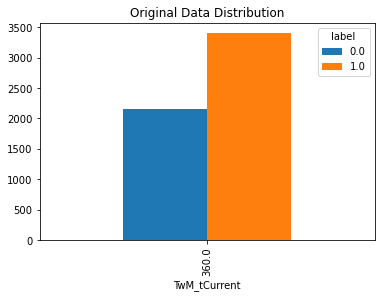

In [8]:
initial_features_path = 'F:\\twitter_data\\givenchy\\pickle\\feature_6_hour.pkl'
user_data_path = 'F:\\twitter_data\\givenchy\\pickle\\users.dat'
model_save_path = 'F:\\twitter_data\\givenchy\\pickle\\trained_model.dat'
model = xgb
data_training_process(user_data_path, initial_features_path, model_save_path, rebalance_method = 'up')
    


# simulation Usage

In [ ]:
network_path = 'F:\\twitter_data\\givenchy\\pickle\\network_simulation_6_hour.pkl'
initial_features_path = 'F:\\twitter_data\\givenchy\\pickle\\feature_6_hour.pkl'
user_data_path = 'F:\\twitter_data\\givenchy\\pickle\\users.dat'
model_path = 'F:\\twitter_data\\givenchy\\pickle\\trained_model.dat'
simulation_result_path = 'F:\\twitter_data\\givenchy\\pickle\\simulation_result_6_hour.pkl'
total_time_duration = 540
interval = 30
current_time = 360

in_degree = list(initial_dataset.friends_count)
out_degree = list(initial_dataset.followers_count)
degree = (users.friends_count+users.followers_count).tolist()


simulation_process(current_time, total_time_duration, interval, initial_features_path, network_path, user_path, model_path, simulation_result_path)